In [1]:
from get_info_followers_and_times import *
from modelo_percepcion import *
from classify import *
from get_scores import *
import seaborn as sns

In [2]:
## Lectura datos tweets 
data=pd.read_csv("entradas/Tweet.csv",delimiter=';')
sentiment_data=pd.read_csv("entradas/ScoreTotalData.csv")
# tweets_predict=pd.read_csv("results/predict_socialmedia.csv")
tweets_predict=predict_from_data(data)
#calculo score de percepcion seguridad
sentiment_data=calculate_scores(sentiment_data)
# sentiment_data=pd.read_csv("results/POS.csv")
# base de datos usuarios y sus seguidores
users_data=pd.read_csv("results/users.csv")
#base de datos reconocimiento de tweets y RT
rt_data=pd.read_csv("results/tweets_from.csv")
tweets=build_dict_info_tweets(sentiment_data,users_data,rt_data,tweets_predict)
# with open("../hawkes/TiDeH-master/data_tweets.pickle", 'rb') as handle:
#     tweets = pickle.load(handle)

In [11]:
tweets_predict

,Id,TweetId,RetweetCount,Favorited,FavoriteCount,Retweeted,PossiblySensitive,Language,Place,FilterLevel,...,CreatedBy,InReplyToScreenName,InReplyToUserIdStr,InReplyToStatusIdStr,InReplyToStatusId,ReplyCount,InReplyToUserId,Sentiment,investment,SentimentText
1074,1075,1107693240084504577,0,0,1,0,0,339,NaN,NaN,...,1075,NaN,NaN,NaN,NaN,NaN,0,"0,0512369275093079",0,Negativo
2532,2533,1107827355442126849,0,0,0,0,0,339,NaN,NaN,...,2533,NaN,NaN,NaN,NaN,NaN,0,0,0,Negativo
1071,1072,1107833756046512128,0,0,1,0,0,339,NaN,NaN,...,1072,NaN,NaN,NaN,NaN,NaN,0,"0,301228880882263",0,Negativo
1069,1070,1107985773503176704,0,0,1,0,0,339,NaN,NaN,...,1070,NaN,NaN,NaN,NaN,NaN,0,"0,0652173906564713",0,Negativo
2482,2483,1108036477982859265,0,0,0,0,0,339,NaN,NaN,...,2483,_p____c_,7.862320e+17,1.108033e+18,1.108033e+18,NaN,786232011782443008,"0,524714350700378",0,Neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701228,1702191,1255112723026915333,3,0,0,0,0,339,NaN,NaN,...,1702192,NaN,NaN,NaN,NaN,NaN,0,"0,27991908788681",0,Negativo
1701367,1702330,1255115005000847360,0,0,0,0,0,339,NaN,NaN,...,1702331,1QueCuenta,3.494686e+09,1.254811e+18,1.254811e+18,NaN,3494686169,"0,311320751905441",0,Negativo
1701413,1702376,1255116529533845504,87,0,0,0,0,339,NaN,NaN,...,1702377,NaN,NaN,NaN,NaN,NaN,0,"0,321220725774765",0,Negativo
1701471,1702434,1255117716270260226,0,0,0,0,0,339,NaN,NaN,...,1702435,sergio_fajardo,2.518531e+07,1.254819e+18,1.254819e+18,NaN,25185308,"0,554947316646576",0,Neutral


In [12]:
sentiment_data

,ID,Date,Time,Tweet,GoogleSentiment,Sentiment,SentimentSimple,SentimentPolarity
0,1,18/03/2019,17:20:23,Hemos impulsado la marcación de bicicletas com...,"0,366633743047714",4,3,3
1,2,18/03/2019,17:20:23,#BOGOTÁ - Desarticulada banda dedicada al hurt...,"0,396044045686722",4,1,2
2,3,18/03/2019,17:20:23,#SondeoADNdeHoy ¿Alguna vez ha sido víctima de...,"0,0512369275093079",3,3,3
3,4,18/03/2019,17:20:23,Estas son las víctimas detrás de un bicicleta ...,"0,179279953241348",3,2,2
4,5,18/03/2019,17:20:23,@NoticiasRCN En lo que va de 2019 se han denun...,"0,502632915973663",3,3,3
...,...,...,...,...,...,...,...,...
26250,26251,16/04/2020,18:37:40,@Soyomarvasquez @ClaudiaLopez Era un atraco en...,NaN,2,2,2
26251,26252,14/04/2020,23:05:05,#ParesReporta l A esta hora Donde estan las ay...,NaN,3,2,2
26252,26253,7/04/2020,20:25:06,@BluRadioCo @mluciaramirez Si lo que preocupa ...,NaN,3,2,2
26253,26254,13/04/2020,20:53:46,Ayuda.\nEn el barrio Belalcazar se fue la luz ...,NaN,3,1,2


In [3]:
print("Datos totales originales:",len(data))
print("Fechas inicial y final:",data.CreatedAt.min(),data.CreatedAt.max())
print("Registros que son RT:",data.IsRetweet.sum())
print("Registos que pasan la clasificación:",len(tweets_predict))
print("Post originales con cuantificación:",len(sentiment_data))
print("Cantidad de usuario en la base de datos:",len(users_data))

Datos totales originales: 1701668
Fechas inicial y final: 2019-03-18 13:17:14.000 2020-04-28 13:06:06.000
Registros que son RT: 1148043
Registos que pasan la clasificación: 106880
Post originales con cuantificación: 26255
Cantidad de usuario en la base de datos: 90780


In [4]:
# ajuste parametros modelo comportamiento temporal
beta, param_fit, predict, x_time = get_predictions(tweets,1000,1720,1890)

In [5]:
beta

array([0.04582902, 0.45150913])

In [6]:
param_fit

array([0.68624032, 4.77871647, 0.05039096])

[Text(0, 0.5, '# Tweets'), Text(0.5, 0, 'time (hours)')]

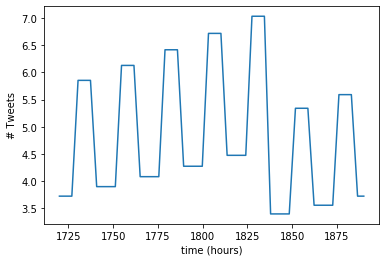

In [10]:
fig=sns.lineplot(x=x_time,y=predict)
fig.set(xlabel='time (hours)', ylabel='# Tweets')